## Understanding the Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Reading the CSV

In [13]:
san_francisco = pd.read_csv("./datasets/Flood_Health_Decile_Sort.csv")
san_francisco.head()

,Census Blockgroup,Children,Elderly,NonWhite,Poverty,Education,English,Elevation,SeaLevelRise,Precipitation,Diabetes,MentalHealth,Asthma,Disability,HousingViolations,Homeless,LivAlone,FloodHealthIndex,Deciles,FloodHealthIndex_Quintiles
0,60759809001,0.072957,8.037850e-10,0.599175,0.356678,0.996080,0.150559,-6.00000,0.182261,0.035771,22.0584,36.5200,15.1339,0.133608,14.10930,17.5025,0.480591,84.8190,10,5
1,60750201001,0.079893,1.240000e-01,0.651000,0.509706,0.724000,0.232000,7.83292,0.000000,0.020516,16.0115,62.0535,10.5741,0.238000,10.24060,15.8921,0.522000,83.4860,10,5
2,60750117001,0.027149,1.030000e-01,0.697000,0.378595,0.862000,0.171000,-1.99906,0.106609,0.005321,1.4068,98.5924,0.8008,0.187000,39.56220,4.9374,0.635000,83.4791,10,5
3,60750178021,0.084215,8.800000e-02,0.584000,0.327362,0.843000,0.119000,-5.96629,0.064579,0.024166,14.9856,54.0699,9.5802,0.229000,7.04366,19.2683,0.427000,82.4925,10,5
4,60750125012,0.095332,2.219991e-01,0.726001,0.794750,0.694997,0.202999,7.13278,0.000000,0.004105,15.5000,63.7499,12.9672,0.424998,13.72550,14.6184,0.731997,81.8061,10,5


### Correlating Variables to FHI

In [14]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr
columns = list(san_francisco.columns)[1:-3]
fhi = san_francisco[['FloodHealthIndex']]

correlationType  = dict()
significant_metrics = {}
for column in columns:
    non_linear_corr, p1 = spearmanr(fhi, san_francisco[column])
    linear_corr, p2 = pearsonr(san_francisco[column], fhi)
    if abs(non_linear_corr) > abs(linear_corr[0]):
        larger_corr = non_linear_corr
        correlationType.update({column: "nonlinear"})
    else:
        larger_corr = linear_corr[0]
        correlationType.update({column: "linear"})
    if abs(larger_corr) >= .4:
        significant_metrics[column] = larger_corr
    print(f"{column}: {larger_corr} ({correlationType[column]})")

significant_metrics

Children: -0.26308733248861554 (nonlinear)
Elderly: 0.07791234487601838 (linear)
NonWhite: 0.47987912437901153 (nonlinear)
Poverty: 0.693046296055 (nonlinear)
Education: -0.5637919102587562 (linear)
English: 0.5150096592691067 (nonlinear)
Elevation: -0.6729305040032092 (nonlinear)
SeaLevelRise: 0.2892299805806113 (nonlinear)
Precipitation: 0.30912072247333705 (linear)
Diabetes: 0.5802448846886352 (nonlinear)
MentalHealth: 0.6621334818266624 (nonlinear)
Asthma: 0.6263732563188594 (nonlinear)
Disability: 0.5605332023005422 (linear)
HousingViolations: 0.20879543570571726 (linear)
Homeless: 0.614698873917741 (nonlinear)
LivAlone: 0.3023663102717023 (linear)


{'NonWhite': 0.47987912437901153,
 'Poverty': 0.693046296055,
 'Education': -0.5637919102587562,
 'English': 0.5150096592691067,
 'Elevation': -0.6729305040032092,
 'Diabetes': 0.5802448846886352,
 'MentalHealth': 0.6621334818266624,
 'Asthma': 0.6263732563188594,
 'Disability': 0.5605332023005422,
 'Homeless': 0.614698873917741}

## Machine Learning Models

In [15]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

X = san_francisco[list(significant_metrics.keys())] 
y = san_francisco[['Deciles']] 

### Permutation Importance Function

In [16]:
def model_permutation_importance(clf, X_test, y_test, significant_metrics):
    perm_importance = permutation_importance(clf, X_test, y_test)

    feature_names = list(significant_metrics.keys())
    features = np.array(feature_names)

    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")

### kNN Model

Best K: 1
Accuracy for Best K: 0.7695402298850575


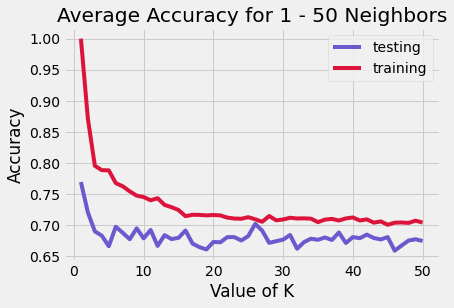

In [17]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
testing_accuracy = []

for i in range(1, 51):
    training_height_accuracy = []
    testing_height_accuracy = []
    for j in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf = KNeighborsClassifier(n_neighbors = i) 
        scaler = StandardScaler() 
        scaler.fit(X_train)
        X_train = scaler.transform(X_train) 
        X_test = scaler.transform(X_test) 
        clf.fit(X_train, np.ravel(y_train,order='C')) 
        y_pred = clf.predict(X_train)
        training_height_accuracy.append(metrics.accuracy_score(y_train, y_pred)
                + metrics.accuracy_score(y_train, [x+1 for x in y_pred])
                + metrics.accuracy_score(y_train, [x-1 for x in y_pred]))
        y_pred = clf.predict(X_test)
        testing_height_accuracy.append(metrics.accuracy_score(y_test, y_pred)
                + metrics.accuracy_score(y_test, [x+1 for x in y_pred])
                + metrics.accuracy_score(y_test, [x-1 for x in y_pred]))
    training_accuracy.append(sum(training_height_accuracy)/len(training_height_accuracy))
    testing_accuracy.append(sum(testing_height_accuracy)/len(testing_height_accuracy))
print(f"Best K: {testing_accuracy.index(max(testing_accuracy)) + 1}")
print(f"Accuracy for Best K: {max(testing_accuracy)}")

plt.plot(range(1,51), testing_accuracy, color = 'slateblue', label = 'testing')
plt.plot(range(1,51), training_accuracy, color = 'crimson', label = 'training')
plt.legend(loc = 'upper right')
plt.xlabel('Value of K') 
plt.ylabel('Accuracy') 
plt.title('Average Accuracy for 1 - 50 Neighbors') 
plt.show()

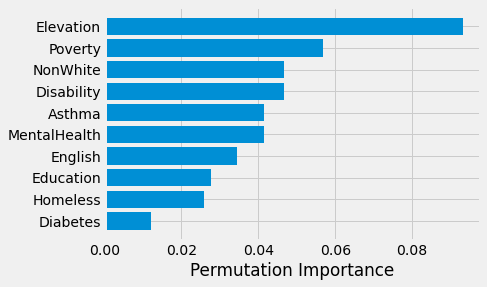

In [18]:
clf = KNeighborsClassifier(n_neighbors = testing_accuracy.index(max(testing_accuracy)) + 1) 
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
clf.fit(X_train, np.ravel(y_train,order='C'))
model_permutation_importance(clf, X_test, y_test, significant_metrics)

### Decision Tree Model

Best Height: 14
Accuracy for Best Height: 0.7517241379310345


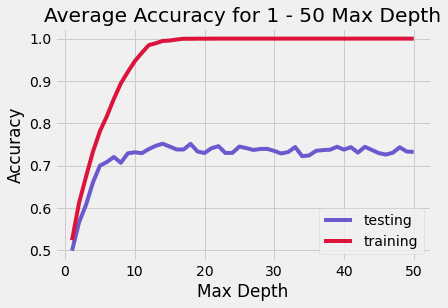

In [19]:
from sklearn.tree import DecisionTreeClassifier

training_accuracy = []
testing_accuracy = []

for i in range(1, 51):
    height_testing_accuracy = []
    height_training_accuracy = []
    for j in range(30):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf = DecisionTreeClassifier(max_depth=i) 
        scaler = StandardScaler() 
        scaler.fit(X_train)
        X_train = scaler.transform(X_train) 
        X_test = scaler.transform(X_test) 
        clf.fit(X_train, np.ravel(y_train,order='C')) 
        y_pred = clf.predict(X_train)
        height_training_accuracy.append(metrics.accuracy_score(y_train, y_pred) + metrics.accuracy_score(y_train, [x+1 for x in y_pred]) + metrics.accuracy_score(y_train, [x-1 for x in y_pred]))
        y_pred = clf.predict(X_test)
        height_testing_accuracy.append(metrics.accuracy_score(y_test, y_pred) + metrics.accuracy_score(y_test, [x+1 for x in y_pred]) + metrics.accuracy_score(y_test, [x-1 for x in y_pred]))
    training_accuracy.append(sum(height_training_accuracy)/len(height_training_accuracy))
    testing_accuracy.append(sum(height_testing_accuracy)/len(height_testing_accuracy))

print(f"Best Height: {testing_accuracy.index(max(testing_accuracy)) + 1}")
print(f"Accuracy for Best Height: {max(testing_accuracy)}")

plt.plot(range(1,51), testing_accuracy, color = 'slateblue', label = 'testing')
plt.plot(range(1,51), training_accuracy, color = 'crimson', label = 'training')
plt.legend(loc="best")
plt.xlabel('Max Depth') 
plt.ylabel('Accuracy') 
plt.title('Average Accuracy for 1 - 50 Max Depth') 
plt.show()

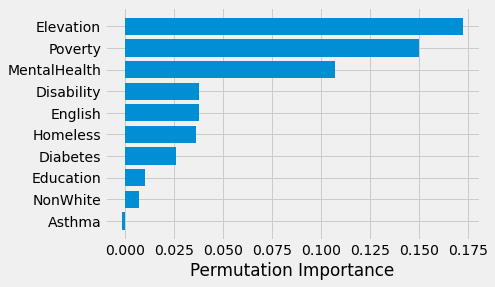

In [20]:
clf = DecisionTreeClassifier(max_depth = testing_accuracy.index(max(testing_accuracy)) + 1) 
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
clf.fit(X_train, np.ravel(y_train,order='C'))
model_permutation_importance(clf, X_test, y_test, significant_metrics)

### Linear Discriminant Analysis

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

accuracy = []
for i in range(0, 1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    clf = LinearDiscriminantAnalysis()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    clf.fit(X_train, np.ravel(y_train,order='C'))
    y_pred = clf.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, y_pred) + metrics.accuracy_score(y_test, [x+1 for x in y_pred]) + metrics.accuracy_score(y_test, [x-1 for x in y_pred]))
print("Accuracy:",sum(accuracy)/len(accuracy))

Accuracy: 0.7003706896551716


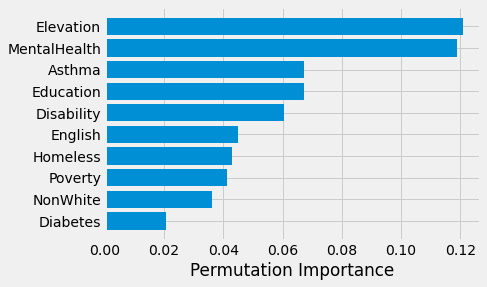

In [22]:
clf = LinearDiscriminantAnalysis()
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
clf.fit(X_train, np.ravel(y_train,order='C'))
model_permutation_importance(clf, X_test, y_test, significant_metrics)

### Support Vector Machine Model

In [23]:
from sklearn.svm import SVC

accuracy = []
for i in range(0, 1000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = SVC(kernel='linear', C = 1) 
    scaler = StandardScaler() 
    scaler.fit(X_train) 
    X_train = scaler.transform(X_train) 
    X_test = scaler.transform(X_test) 
    clf.fit(X_train, np.ravel(y_train,order='C')) 
    y_pred = clf.predict(X_test)
    from sklearn import metrics
    accuracy.append(metrics.accuracy_score(y_test, y_pred) + metrics.accuracy_score(y_test, [x+1 for x in y_pred]) + metrics.accuracy_score(y_test, [x-1 for x in y_pred]))

print("Accuracy:",sum(accuracy)/len(accuracy))

Accuracy: 0.7554224137931023


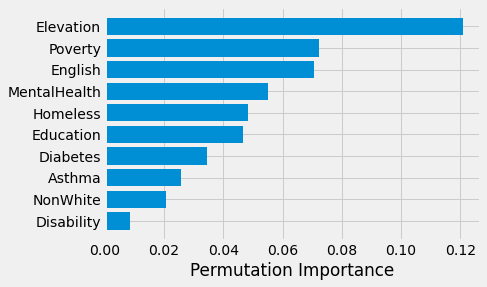

In [24]:
clf = SVC(kernel = 'linear', C = 1) 
scaler = StandardScaler() 
scaler.fit(X_train)
X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 
clf.fit(X_train, np.ravel(y_train,order='C'))
model_permutation_importance(clf, X_test, y_test, significant_metrics)